# Informe Accidentalidad - Barranquilla

### Descargamos e importamos instancias necesarias

In [ ]:
%pip install sodapy
%pip install geopy
%pip install folium
import pandas as pd
from sodapy import Socrata
import requests
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt

# Configuración de no truncar visualización de los DF.
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

### Obtenemos los datos de: https://www.datos.gov.co/Transporte/Accidentalidad-Barranquilla-detalle-de-Veh-culos/yb9r-2dsi/about_data

In [70]:
client = Socrata("www.datos.gov.co", None)
results = client.get("yb9r-2dsi", limit=50000)
results_df = pd.DataFrame.from_records(results)

### Obetenemos un poco de información acerca de nuestros datos generales de accidentalidad en la ciudad de Barranquilla.

In [71]:
results_df = results_df.map(lambda x: x.lower() if isinstance(x, str) else x)
meses_a_numeros = {
    'enero': 1,
    'febrero': 2,
    'marzo': 3,
    'abril': 4,
    'mayo': 5,
    'junio': 6,
    'julio': 7,
    'agosto': 8,
    'septiembre': 9,
    'octubre': 10,
    'noviembre': 11,
    'diciembre': 12
}
results_df['mes_accidente'] = results_df['mes_accidente'].replace(meses_a_numeros)
results_df['hora_accidente'] = pd.to_datetime(results_df['hora_accidente'], format='%I:%M:%S:%p')
results_df['fecha_accidente'] = pd.to_datetime(results_df['fecha_accidente'], format='mixed').dt.date
results_df['cant_heridos_en_sitio_accidente'] = results_df['cant_heridos_en_sitio_accidente'].fillna(0)


In [22]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43472 entries, 0 to 43471
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   fecha_accidente                  43472 non-null  object
 1   a_o_accidente                    43472 non-null  object
 2   mes_accidente                    43472 non-null  int64 
 3   dia_accidente                    43472 non-null  object
 4   hora_accidente                   43472 non-null  object
 5   gravedad_accidente               43472 non-null  object
 6   clase_accidente                  43472 non-null  object
 7   sitio_exacto_accidente           43471 non-null  object
 8   cant_heridos_en_sitio_accidente  43472 non-null  object
 9   cantidad_accidentes              43472 non-null  object
 10  cant_muertos_en_sitio_accidente  321 non-null    object
dtypes: int64(1), object(10)
memory usage: 3.6+ MB


In [5]:
results_df.describe(include='all')

,fecha_accidente,a_o_accidente,mes_accidente,dia_accidente,hora_accidente,gravedad_accidente,clase_accidente,sitio_exacto_accidente,cant_heridos_en_sitio_accidente,cantidad_accidentes,cant_muertos_en_sitio_accidente
count,43472,43472,43472.000000,43472,43472,43472,43472,43471,11019,43472,321
unique,3158,9,NaN,14,1006,3,6,23421,21,2,2
top,2017-02-17t00:00:00.000,2016,NaN,mar,04:00:00:pm,solo daños,choque,cl 17 cr 8,1,1,1
freq,34,6520,NaN,6733,742,32242,41021,106,7665,43462,312
mean,NaN,NaN,6.457904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,3.467165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Aquí podemos encontrar datos interesantes como por ejemplo:

1. El año en que se presentarón mas accidentes fue 2018, con un total de 10606.
2. El mes donde generalmente se presentan mas accidentes es febrero, con un total de 4173.
3. La ubicación de la ciudad con mas accidentes desde 2028 hasta agosto de 2023 fue CL 110 CR 9G.

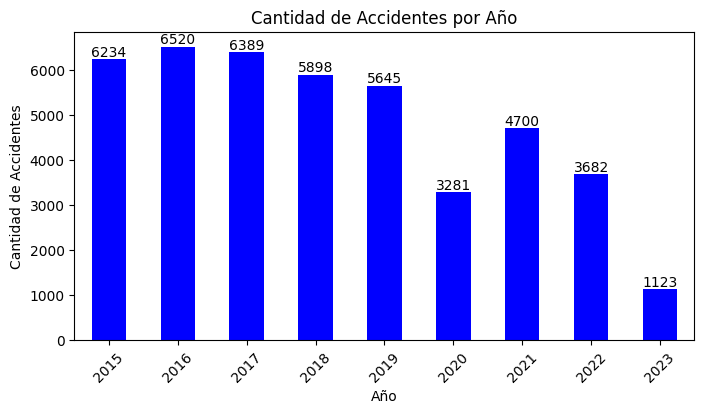

In [40]:
accidentes_por_año = results_df['a_o_accidente'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
bar_one = accidentes_por_año.plot.bar(x=accidentes_por_año.index, y=accidentes_por_año.values, color='blue')
plt.title('Cantidad de Accidentes por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(accidentes_por_año.values):
    bar_one.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

##### Con este grafico podemos ver que el año en el que se presentaron mas accidentes fue en 2018. Finalmente, hay que tener en cuenta que nuestro dataset tiene un limite de datos en 2023 hasta octubre. Por lo tanto, no llegamos a tener mas de 2000 accidentes desde enero hasta agosto.

##### Ahora bien, queremos ver el comportamiento de todos los años registrados desde enero hasta agosto, para poder tener una comparación equitativa y ver el comportamiento grafico hasta esa fecha.

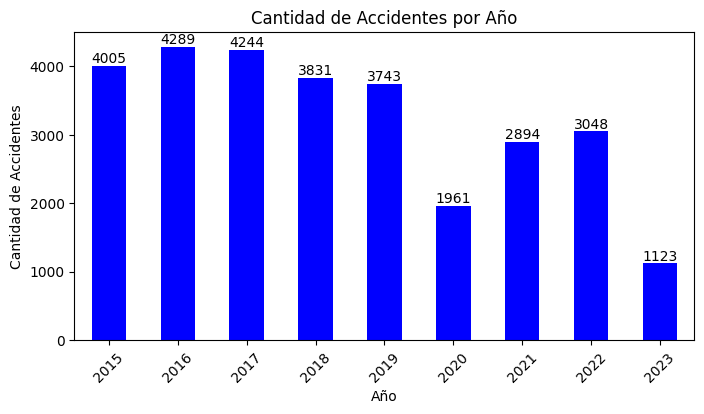

In [46]:
accidentes_enero_agosto = results_df[(results_df['mes_accidente'] >= 1) & (results_df['mes_accidente'] <= 8)]

accidentes_por_año_enero_agosto = accidentes_enero_agosto['a_o_accidente'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
bar_two = accidentes_por_año_enero_agosto.plot.bar(x=accidentes_por_año_enero_agosto.index, y=accidentes_por_año_enero_agosto.values, color='blue')
plt.title('Cantidad de Accidentes por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(accidentes_por_año_enero_agosto.values):
    bar_two.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

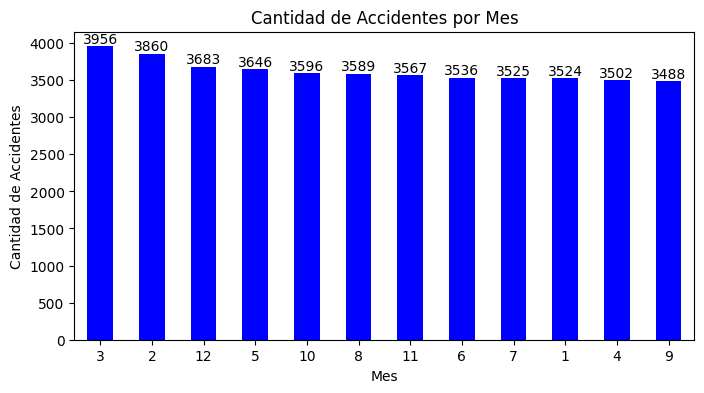

In [105]:
df_accidentes_por_mes = results_df['mes_accidente'].value_counts()
df_accidentes_por_mes.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8, 4))
bar_three = df_accidentes_por_mes.plot.bar(x=df_accidentes_por_mes.index, y=df_accidentes_por_mes.values, color='blue')
plt.title('Cantidad de Accidentes por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=0)
for i, valor in enumerate(df_accidentes_por_mes.values):
    bar_three.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

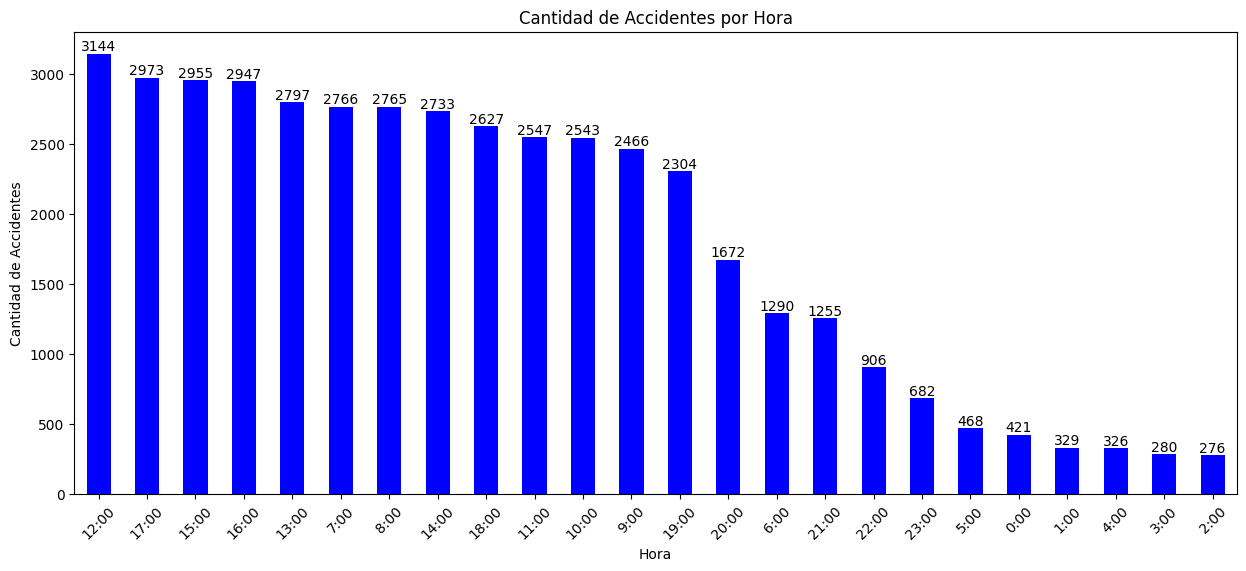

In [106]:
df_agrupado_por_hora = results_df.groupby(results_df['hora_accidente'].dt.hour).size()
df_agrupado_por_hora.index = df_agrupado_por_hora.index.astype(str) + ':00'
df_agrupado_por_hora.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(15, 6))
bar_three = df_agrupado_por_hora.plot.bar(x=df_agrupado_por_hora.index, y=df_agrupado_por_hora.values, color='blue')
plt.title('Cantidad de Accidentes por Hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(df_agrupado_por_hora.values):
    bar_three.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()


### Ahora, a partir de aquí, queremos hacer un analisis de estos datos de accidentalidad en este año 2023.

In [87]:
df_2023 = results_df[results_df["a_o_accidente"] == "2023"]

In [88]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1123 entries, 42349 to 43471
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   fecha_accidente                  1123 non-null   object        
 1   a_o_accidente                    1123 non-null   object        
 2   mes_accidente                    1123 non-null   int64         
 3   dia_accidente                    1123 non-null   object        
 4   hora_accidente                   1123 non-null   datetime64[ns]
 5   gravedad_accidente               1123 non-null   object        
 6   clase_accidente                  1123 non-null   object        
 7   sitio_exacto_accidente           1123 non-null   object        
 8   cant_heridos_en_sitio_accidente  1123 non-null   object        
 9   cantidad_accidentes              1123 non-null   object        
 10  cant_muertos_en_sitio_accidente  24 non-null     object     

In [89]:
df_2023.describe(include='all')

,fecha_accidente,a_o_accidente,mes_accidente,dia_accidente,hora_accidente,gravedad_accidente,clase_accidente,sitio_exacto_accidente,cant_heridos_en_sitio_accidente,cantidad_accidentes,cant_muertos_en_sitio_accidente
count,1123,1123,1123.000000,1123,1123,1123,1123,1123,1123,1123,24
unique,243,1,NaN,7,NaN,3,6,1036,12,1,1
top,2023-06-05,2023,NaN,domingo,NaN,con heridos,choque,calle 110 carrera 43,1,1,1
freq,13,1123,NaN,174,NaN,1092,944,7,716,1123,24
mean,NaN,NaN,4.459484,NaN,1900-01-01 12:56:29.599287552,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,1900-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.000000,NaN,1900-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,4.000000,NaN,1900-01-01 12:55:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,6.000000,NaN,1900-01-01 17:37:30,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,8.000000,NaN,1900-01-01 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN


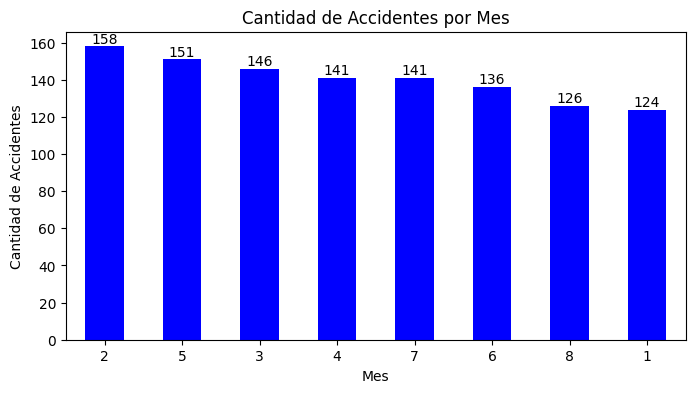

In [101]:
df_2023_por_meses = df_2023['mes_accidente'].value_counts()
df_2023_por_meses.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8, 4))
bar_four = df_2023_por_meses.plot.bar(x=df_2023_por_meses.index, y=df_2023_por_meses.values, color='blue')
plt.title('Cantidad de Accidentes por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=0)
for i, valor in enumerate(df_2023_por_meses.values):
    bar_four.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

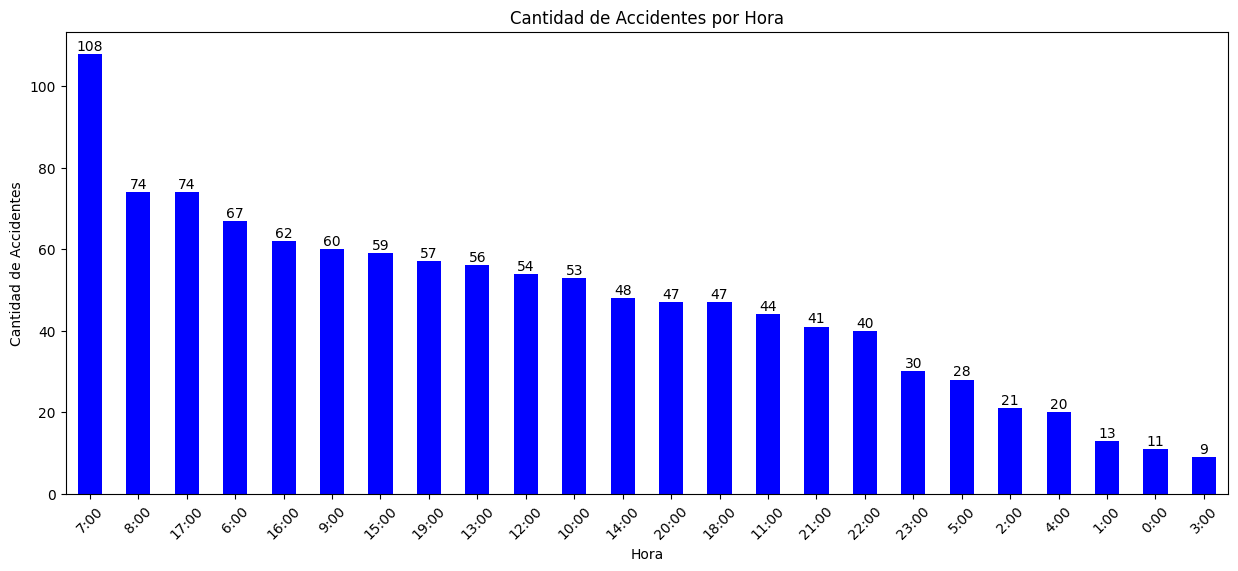

In [109]:
df_2023_por_horas = df_2023.groupby(df_2023['hora_accidente'].dt.hour).size()
df_2023_por_horas.index = df_2023_por_horas.index.astype(str) + ':00'
df_2023_por_horas.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(15, 6))
bar_five = df_2023_por_horas.plot.bar(x=df_2023_por_horas.index, y=df_2023_por_horas.values, color='blue')
plt.title('Cantidad de Accidentes por Hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Accidentes')
plt.xticks(rotation=45)
for i, valor in enumerate(df_2023_por_horas.values):
    bar_five.text(i, valor + 0.2, str(valor), ha='center', va='bottom')
plt.show()

In [109]:
# Función para obtener la latitud y longitud de una dirección con Geopy
def obtener_latitud_longitud_geopy(direccion):
    geolocator = Nominatim(user_agent="my_geocoder")
    try:
        location = geolocator.geocode(direccion, timeout=10)
    except Exception as e:
        print(f"Error en la solicitud Geopy: {e}")
        location = None

    if location:
        latitud = location.latitude
        longitud = location.longitude
        return latitud, longitud
    else:
        return None, None


# Función para obtener la latitud y longitud de una dirección con Azure Maps
def obtener_latitud_longitud_azure(direccion):
    
    url = f"https://atlas.microsoft.com/search/address/json?api-version=1.0&subscription-key={'API_KEY'}&query={direccion}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if data.get('results'):
            location = data['results'][0]['position']
            return location['lat'], location['lon']

    # Devuelve valores predeterminados si no se encuentra la ubicación
    return None, None


def obtener_latitud_longitud(direccion):
    latitud, longitud = obtener_latitud_longitud_geopy(direccion)

    if latitud is None or longitud is None:
        latitud, longitud = obtener_latitud_longitud_azure(direccion)

    return latitud, longitud

In [111]:
latlong = []
# Iterar sobre las direcciones y obtener latitud y longitud
for direccion in df_2023['sitio_exacto_accidente']:
    latitud, longitud = obtener_latitud_longitud_azure(f"{direccion}, Barranquilla, Atlántico, Colombia")
    latlong.append({'Latitud': latitud, 'Longitud': longitud})

# Crear un DF con las latitudes y longitudes
latlong_df = pd.DataFrame(latlong)
# Guardar el DF en un archivo CSV
latlong_df.to_csv('accidentes_bquilla_2023_azure.csv')

In [112]:
# Leer el archivo CSV con las latitudes y longitudes
df_clean_accidentes_2023 = pd.read_csv("accidentes_bquilla_2023_azure.csv")

In [113]:
df_clean_accidentes_2023.dropna(inplace=True)
print(f"Dimensiones del DF: {df_clean_accidentes_2023.shape}")

Dimensiones del DF: (1122, 3)


In [118]:
lat_min, lat_max = 10.8, 11.1
lon_min, lon_max = -75.0, -74.5

geoinfo_area_metropolitana_quilla = df_clean_accidentes_2023[
    (df_clean_accidentes_2023['Latitud'] >= lat_min) & (df_clean_accidentes_2023['Latitud'] <= lat_max) &
    (df_clean_accidentes_2023['Longitud'] >= lon_min) & (df_clean_accidentes_2023['Longitud'] <= lon_max)
]

print(f"Dimensiones del DF: {geoinfo_area_metropolitana_quilla.shape}")

Dimensiones del DF: (1035, 3)


In [123]:
# Crea un objeto gmplot centrado en las coordenadas promedio
barranquilla_map = folium.Map(location=[geoinfo_area_metropolitana_quilla['Latitud'].iloc[0], geoinfo_area_metropolitana_quilla['Longitud'].iloc[0]], zoom_start=13)

# Agrega marcadores para cada accidente en el DataFrame
for index, row in geoinfo_area_metropolitana_quilla.iterrows():
    folium.Marker(location=[row['Latitud'], row['Longitud']]).add_to(barranquilla_map)

# Mostrar el mapa
barranquilla_map

In [125]:
mapa_cluster = folium.Map(location=[geoinfo_area_metropolitana_quilla['Latitud'].iloc[0], geoinfo_area_metropolitana_quilla['Longitud'].iloc[0]], zoom_start=12)
marker_cluster = MarkerCluster().add_to(mapa_cluster)

for index, row in geoinfo_area_metropolitana_quilla.iterrows():
    folium.Marker(location=[row['Latitud'],  row['Longitud']]).add_to(marker_cluster)

mapa_cluster